## DynaQ - Grid World Example

This time we will use an environment from the [<tt>GridWorlds.jl</tt>](https://github.com/JuliaReinforcementLearning/GridWorlds.jl) package:

In [1]:
using ReinforcementLearningBase, GridWorlds
using PyPlot

world = GridWorlds.GridRoomsDirectedModule.GridRoomsDirected();
env = GridWorlds.RLBaseEnv(world)

# RLBaseEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |   InternalState{Any}() |
| DefaultStateStyle |   InternalState{Any}() |

## Is Environment Terminated?

No

## State Space

`nothing`

## Action Space

`Base.OneTo(4)`

## Current State

```
([0 0 0 0 0 0 0 0 0; 1 1 1 1 1 1 1 1 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 1 0 1 1 1 0 1 1; 0 0 0 0 0 0 0 0 0;;; 0 0 1 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 1 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 1 1 1 1 1 1 1 1; 0 0 0 0 0 0 0 0 0], 2)
```


Now, we will define agent (note how it differs from the basic TD learning):

In [2]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64 #współczynnik eksploracji
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64 #dyskonto
    α::Float64 #stopa uczenia się
    planning::Int64 #liczba krokow planowania
    Q::Dict
    model::Dict
    score::Int #wynik - ile razy agent dotarl do mety
end

function Agent(env, planning_steps; ϵ = 1.0, ϵ_decay = 0.9975, ϵ_min = 0.005,
        β = 0.99, α = 0.1) 
    Agent(env,
        ϵ, ϵ_decay, ϵ_min, β, α, 
        planning_steps, 
        Dict(), Dict(), 0.0)
end

Agent

It is time to define the model approximation function. In our case it is simple, usually it is far more complicated:

In [3]:
feed!(agent,state, action, reward, new_state) = (agent.model[(state,action)] = (new_state, reward))

feed! (generic function with 1 method)

Learning function:

In [4]:
function learn!(agent, state, action, reward, new_state)
    if !haskey(agent.Q, state)
        agent.Q[state] = zeros(length(action_space(agent.env)))
        agent.Q[state][action] = reward
    else
        Q_next_state = 0.0
        haskey(agent.Q, new_state) && ( Q_next_state += maximum(agent.Q[new_state]))
        agent.Q[state][action] += agent.α * (reward + agent.β*Q_next_state - agent.Q[state][action])
    end
    
end

learn! (generic function with 1 method)

Finally, the main loop:

In [5]:
function dyna_Q!(agent, steps; burning = true, animated = nothing) 
    step = 1.0
    episode = 0.0
    if !isnothing(animated)
        global str = ""
        global str = str * "FRAME_START_DELIMITER"
        global str = str * "step: $(step)\n"
        global str = str * "episode: $(episode)\n"
        global str = str * repr(MIME"text/plain"(), env)
        global str = str * "\ntotal_reward: 0"
    end
    while step <= steps
        if (burning && step < 0.1*steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
            action = rand(1:length(action_space(agent.env)))
        else 
            action = argmax(agent.Q[state(agent.env)])
        end
        S = deepcopy(state(agent.env))
        agent.env(action_space(agent.env)[action])
        r = reward(agent.env)
        learn!(agent, S, action, r, deepcopy(state(agent.env)))
        feed!(agent, S, action, r, deepcopy(state(agent.env)))
        for i = 1:agent.planning
            (S,a),(next_S, R) = rand(agent.model)
            learn!(agent, S, a, R, next_S)
        end 
        if !isnothing(animated) 
            global str = str * "FRAME_START_DELIMITER"
            global str = str * "step: $(step)\n"
            global str = str * "episode: $(episode)\n"
            global str = str * repr(MIME"text/plain"(), env)
            global str = str * "\ntotal_reward: $(agent.score)"
        end
        if is_terminated(agent.env)
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
            agent.score += 1.0
            episode += 1.0
            reset!(agent.env)
        end
        step += 1.0 
    end
    if !isnothing(animated) 
        write(animated * ".txt", str)
    end
end

dyna_Q! (generic function with 1 method)

Let us test if everything work. DynaQ before learning:

In [6]:
agent = Agent(env,5);

dyna_Q!(agent, 100, animated = "before_learning")
#animation - works only in command line!
#GridWorlds.replay(file_name = "before_learning.txt", frame_start_delimiter = "FRAME_START_DELIMITER", frame_rate = 5)

55339

and after learning:

In [7]:
dyna_Q!(agent, 1_000_000)
@info "agent score: $(agent.score)"

dyna_Q!(agent, 1000, burning = false, animated = "after_learning")
#animation - works only in command line!
#GridWorlds.replay(file_name = "after_learning.txt", frame_start_delimiter = "FRAME_START_DELIMITER",  frame_rate = 5)

[ Info: agent score: 111622


555472

Now, let us take a look at different numbers of planning steps:

In [8]:
@info "agent 0 steps of planning (Q-learning)"
agent = Agent(env,0);
@time dyna_Q!(agent, 1_000_000)
@info "agent score: $(agent.score)"

@info "agent 10 steps of planning"
agent = Agent(env,10);
@time dyna_Q!(agent, 1_000_000)
@info "agent score: $(agent.score)"

@info "agent 30 steps of planning"
agent = Agent(env,30);
@time dyna_Q!(agent, 1_000_000)
@info "agent score: $(agent.score)"

[ Info: agent 0 steps of planning (Q-learning)


  8.919389 seconds (55.37 M allocations: 2.443 GiB, 6.19% gc time)


[ Info: agent score: 1439
[ Info: agent 10 steps of planning


 76.286958 seconds (503.72 M allocations: 14.916 GiB, 5.52% gc time)


[ Info: agent score: 108074
[ Info: agent 30 steps of planning


203.431927 seconds (1.40 G allocations: 39.872 GiB, 5.76% gc time)


[ Info: agent score: 110637


### Experiment

<i>Score for different numbers of planning steps:</i>

In [9]:
#this experiment is pretty slow!

using Random; Random.seed!(234)

res = []
times = []
for i in 0:3:25
    scores = []
    times_steps = []
    for j in 1:5
        agent = Agent(env, i);
        t = @elapsed dyna_Q!(agent, 100_000)
        push!(scores,agent.score)
        push!(times_steps, t)
    end
    push!(res,sum(scores)/length(scores))
    push!(times,sum(times_steps)/length(times_steps))
end

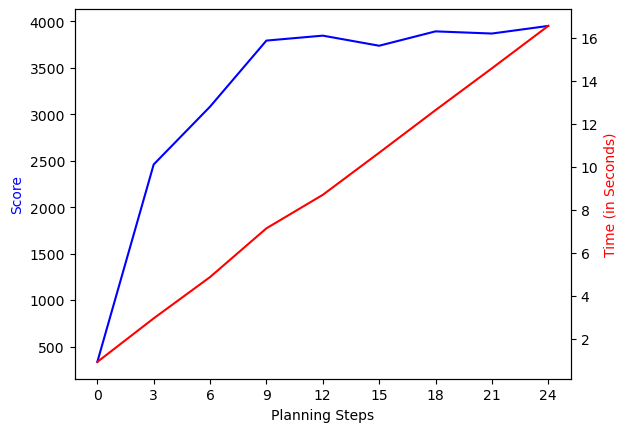

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x0000017C361CA610>, PyObject <matplotlib.axis.XTick object at 0x0000017C361C8B10>, PyObject <matplotlib.axis.XTick object at 0x0000017C3616BE10>, PyObject <matplotlib.axis.XTick object at 0x0000017C656194D0>, PyObject <matplotlib.axis.XTick object at 0x0000017C6561AA50>, PyObject <matplotlib.axis.XTick object at 0x0000017C65620C10>, PyObject <matplotlib.axis.XTick object at 0x0000017C65622FD0>, PyObject <matplotlib.axis.XTick object at 0x0000017C656291D0>, PyObject <matplotlib.axis.XTick object at 0x0000017C65629A90>], PyCall.PyObject[PyObject Text(0, 0, '0'), PyObject Text(1, 0, '3'), PyObject Text(2, 0, '6'), PyObject Text(3, 0, '9'), PyObject Text(4, 0, '12'), PyObject Text(5, 0, '15'), PyObject Text(6, 0, '18'), PyObject Text(7, 0, '21'), PyObject Text(8, 0, '24')])

In [10]:
PyPlot.plot(res, color = "blue", label = "Score")
ylabel("Score", color = "blue")
xlabel("Planning Steps")
twinx()
PyPlot.plot(times, color = "red", label = "Time")
ylabel("Time (in Seconds)",color = "red")
xticks(0:8,string.(collect(0:3:25)))